imports

In [1]:
import os
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel
from tavily import TavilyClient
from typing import TypedDict, List

c:\Users\GIHAN LAKMAL\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


llm define

In [2]:
from langchain_groq import ChatGroq
model=ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct" , temperature=0.1 , api_key="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")

Api Keys and Agent State Define

In [3]:
os.environ['TAVILY_API_KEY'] = "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"

# Set the conversation memory type
memory = SqliteSaver.from_conn_string(":memory:")

# Data structure of the agent state information
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int


Prompt

In [4]:
PLAN_PROMPT = """You are an expert writer tasked with writing a report. \
Write a report for the user provided topic. Give an outline of the report along with any relevant notes \
or instructions for the sections."""

WRITER_PROMPT = """You are a report assistant tasked with writing excellent reports.\
Generate the best report possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Use all the information below as needed: 
------ 
{content}"""

REFLECTION_PROMPT = """You are a critic reviewing a report. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """
You are a research assistant. Given the user task, produce exactly a JSON object 
matching the following schema:

{
    "queries": ["string1", "string2", ...]
}

Do not include explanations, text, or any extra fields. Only output valid JSON.
"""


RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


Agents and State Define

In [5]:
# Queries list for the Tavily search tool
class Queries(BaseModel):
    queries: List[str]

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    # Call LLM to produce research queries in structured JSON
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])

    # Initialize content safely
    content = state.get('content', [])

    # Run Tavily searches for each query
    for q in queries.queries:
        try:
            response = tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        except Exception as e:
            print(f"Tavily search failed for query '{q}': {e}")

    # Return updated state
    return {"content": content}


def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }

def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    critique_text = state.get("critique", "No critique available")

    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=critique_text)
    ])

    content = state.get('content', [])
    for q in queries.queries:
        try:
            response = tavily.search(query=q, max_results=2)
            for r in response.get('results', []):
                content.append(r.get('content', ''))
        except Exception as e:
            print(f"Skipping query '{q}' due to error: {e}")

    return {"content": content}


def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"




graph building

In [6]:
# Initialise the graph with the agent state
builder = StateGraph(AgentState)

# Add all the nodes (agents)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the starting agent
builder.set_entry_point("planner")

# Set the conditional edge
# This decides, whether to do another refinement loop, or to end
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

# Agent workflow ("generate" is already covered by the conditional edge)
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile with the chosen memory type
graph = builder.compile(checkpointer=memory)

# Run it!
thread = {"configurable": {"thread_id": "1"}}

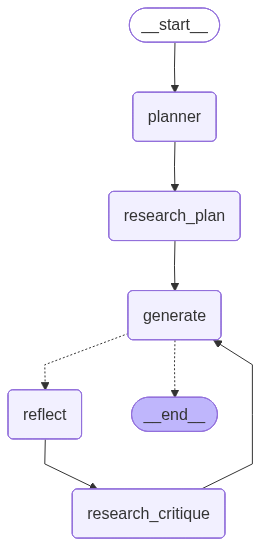

In [7]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
print("graph.checkpointer:", getattr(graph, "checkpointer", None))
print("type(graph.checkpointer):", type(getattr(graph, "checkpointer", None)))
# If you have a 'memory' variable you passed earlier:
print("memory repr:", repr(memory))
print("memory type:", type(memory))
graph = builder.compile(checkpointer=None)

graph.checkpointer: <contextlib._GeneratorContextManager object at 0x00000251352106D0>
type(graph.checkpointer): <class 'contextlib._GeneratorContextManager'>
memory repr: <contextlib._GeneratorContextManager object at 0x00000251352106D0>
memory type: <class 'contextlib._GeneratorContextManager'>


In [9]:
input_payload = {
    "task": "Write a report about the latest inflation figures in the European Union.",
    "max_revisions": 2,
    "revision_number": 1,
}

# required config the stream expects when a checkpointer is present
config = {
    "configurable": {
        "thread_id": "thread-1",        # REQUIRED (one of thread_id/checkpoint_ns/checkpoint_id)
        "checkpoint_ns": "eu_inflation",# optional but useful
        "checkpoint_id": "rev-1",       # optional
    }
}

for s in graph.stream(input_payload, config=config):
    print(s)

{'planner': {'plan': "**Report: Latest Inflation Figures in the European Union**\n\n**I. Executive Summary**\n\n* Brief overview of the report's main findings\n* Summary of the current inflation trends in the European Union\n\n**II. Introduction**\n\n* Context: Brief explanation of the importance of inflation and its impact on the economy\n* Purpose: Explanation of the report's objective, which is to analyze the latest inflation figures in the European Union\n* Sources: List of reliable sources used to gather data, such as Eurostat, European Central Bank, and national statistical agencies\n\n**III. Latest Inflation Figures**\n\n* Overview of the current inflation rate in the European Union (EU) and the Eurozone\n* Analysis of the latest data from Eurostat, including:\n\t+ The Harmonized Index of Consumer Prices (HICP) for the EU and Eurozone\n\t+ Inflation rates for individual EU member states\n\t+ Breakdown of inflation by category (e.g., food, energy, services)\n\n**IV. Trends and An